In [1]:
# Test decoding with LibROSA and TorchAudio

In [12]:
from glob import glob
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import tensorflow as tf
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from tqdm import tqdm

In [15]:
SAMPLE_FILE = "/app/_data/competition_data/train_short_audio/littin1/XC238228.ogg"
TARGET_LEN_S = 5

In [16]:
ipd.Audio(SAMPLE_FILE)

In [5]:
x_lr, sr_lr = librosa.load(SAMPLE_FILE, sr=32000)
x_lr.shape, sr_lr, x_lr.shape[0] / sr_lr

((524192,), 32000, 16.381)

In [6]:
x_t, sr_t = torchaudio.load(SAMPLE_FILE)
x_t = x_t.numpy().flatten()
x_t.shape, sr_t, x_t.shape[0] / sr_t

((524192,), 32000, 16.381)

In [7]:
x_lr - x_t

array([-4.0516024e-06, -6.8568625e-07,  8.2704282e-06, ...,
       -1.5751536e-06, -9.0075565e-07, -2.2480763e-06], dtype=float32)

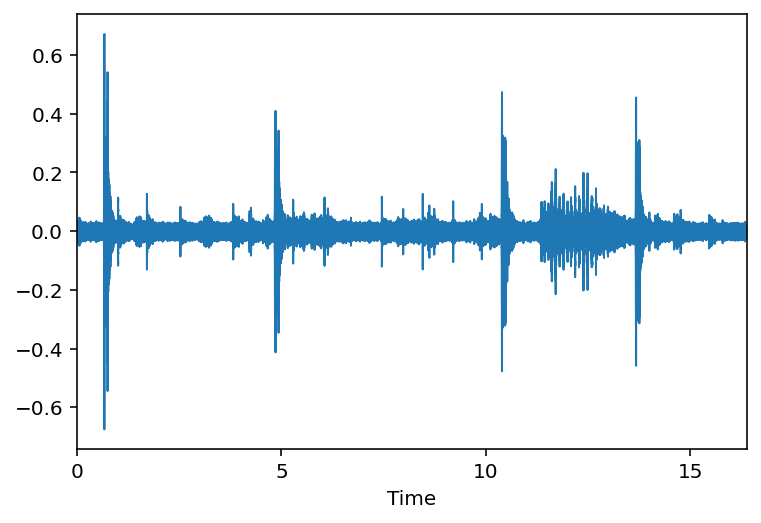

In [8]:
librosa.display.waveplot(x_lr, sr=sr_lr, x_axis="time")

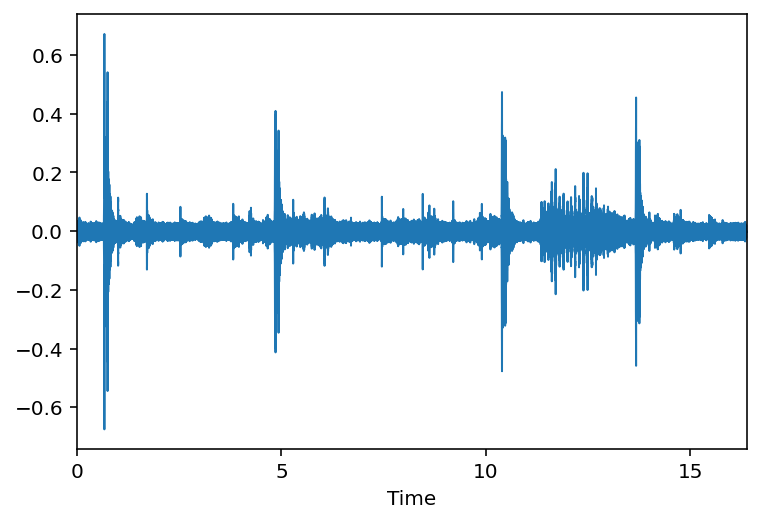

In [9]:
librosa.display.waveplot(x_t, sr=sr_lr, x_axis="time")

In [10]:
def load_lr(_):
    librosa.load(SAMPLE_FILE, sr=32000)


def load_t(_):
    torchaudio.load(SAMPLE_FILE)

for i in tqdm(range(100)):
    load_lr(i)


for i in tqdm(range(100)):
    load_t(i)

with Pool(cpu_count()) as pool:
    _ = list(
        tqdm(
            pool.imap(
                load_lr,
                range(10_000),
            ),
            total=10_000,
            smoothing=0,
        )
    )

with Pool(cpu_count()) as pool:
    _ = list(
        tqdm(
            pool.imap(
                load_t,
                range(10_000),
            ),
            total=10_000,
            smoothing=0,
        )
    )

100%|██████████| 10000/10000 [00:09<00:00, 1042.35it/s]


In [28]:
paths = glob("/app/_data/competition_data/train_short_audio/**/*.ogg")

def load_lr2(i):
    x, sr = librosa.load(paths[i], sr=32000)
    x = x.astype(np.float16)
    return [
        sr,  # sr
        x.shape[0] / sr,  # len [s]
        x.itemsize * x.size,  # size [bytes]
    ]

with Pool(cpu_count()) as pool:
    info = list(
        tqdm(
            pool.imap(
                load_lr2,
                range(len(paths)),
            ),
            total=len(paths),
            smoothing=0,
        )
    )

info = np.array(info)
print(f"Total data size: {np.sum(info[:, 2]) / 2**30:.0f}GB")
print(f"Average length [sec]: {np.mean(info[:, 1]):.1f}")
print(f"Non 32KHz samples: {len(np.where(info[:, 0] != 32000)[0])}")

100%|██████████| 62874/62874 [03:17<00:00, 317.99it/s]

Total data size: 211GB
Average length [sec]: 56.3
Non 32KHz samples: 0
